# Song Lyrics Data Collection using Genius API and Billboard Top 100 from 1960 - 2021


In [1]:
# Importing all Dependencies

# Installing Genius Lyrics API
!pip install lyricsgenius -q
import lyricsgenius

# Installing Billboard API
!pip install billboard.py -q
import billboard

# Installing Beautiful Soup for Webscraping
import requests
from bs4 import BeautifulSoup

# Basic Packages for Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import h5py
import re

from google.colab import (drive, files)
import os
import pandas as pd
import numpy as np

     |████████████████████████████████| 59 kB 1.9 MB/s 


In [2]:
drive.mount('/content/gdrive', force_remount=True)
path = "/content/gdrive"
os.chdir(path)

Mounted at /content/gdrive


In [3]:
## Get data from the CSVs we scraped -- check that it's all 6201 rows
songs_data = pd.read_csv('MyDrive/W266_Final_Project/billboard_songs_lyrics.csv')
## rename a poorly-named column
songs_data = songs_data.rename(columns = {"Unnamed: 0": "Yearly Rank"})
songs_data

,Year,Title,Artist(s),Lyrics,Yearly Rank
0,1960.0,"""Theme from A Summer Place""",Percy Faith,Theme From A Summer Place LyricsThere's a summ...,0.0
1,1960.0,"""He'll Have to Go""",Jim Reeves,He’ll Have To Go Lyrics[Verse 1] Put your swee...,1.0
2,1960.0,"""Cathy's Clown""",The Everly Brothers,Cathy’s Clown Lyrics[Chorus] Don't want your l...,2.0
3,1960.0,"""Running Bear""",Johnny Preston,Running Bear LyricsOn the bank of the river St...,3.0
4,1960.0,"""Teen Angel""",Mark Dinning,Teen Angel LyricsTeen Angel Teen Angel Teen An...,4.0
...,...,...,...,...,...
6196,2021.0,"""Things a Man Oughta Know""",Lainey Wilson,Things a Man Oughta Know Lyrics[Verse 1] I can...,95.0
6197,2021.0,"""Throat Baby (Go Baby)""",BRS Kash,Throat Baby (Go Baby) Lyrics[Intro] (What's ha...,96.0
6198,2021.0,"""Tombstone""",Rod Wave,"Tombstone Lyrics[Intro] Damn, this motherfucke...",97.0
6199,2021.0,"""Drinkin' Beer. Talkin' God. Amen.""",Chase Rice featuring Florida Georgia Line,None,98.0


In [4]:
## Replace the incorrect artist names with the correct ones (straight from Billboard/Wiki charts)
all_artists = []
for year in range(1960, 2022):
  
  # Declaring some variables
  new_songs_df = pd.DataFrame(columns=['Year', 'Title', 'Artist(s)', 'Lyrics'])#, 'Genre'])
  website_root = "https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_"
  table_class ="wikitable sortable jquery-tablesorter"

  wiki_website_url = website_root + str(year) # e.g. "https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1960"
  response = requests.get(wiki_website_url) # getting website response 

  soup = BeautifulSoup(response.text, 'html.parser') # grabbing text using beautiful soup and parsing HTML
  indiatable = soup.find('table',{'class':"wikitable"}) # finding wikipedia Billboard table
  billboard_hot100 = pd.read_html(str(indiatable))
  billboard_hot100 = pd.DataFrame(billboard_hot100[0])

  # Collecting Values
  songs_artists = billboard_hot100['Artist(s)'].values

  all_artists.extend(songs_artists)

songs_data['Artist(s)'] = all_artists

In [5]:
## Add column Num Chars that tracks the # of Characters in each song
songs_data["Num Chars"] = songs_data["Lyrics"].apply(len)
## Add column Num Words that tracks the # of Words in each song
songs_data["Num Words"] = songs_data["Lyrics"].str.split().str.len()
songs_data.head()

,Year,Title,Artist(s),Lyrics,Yearly Rank,Num Chars,Num Words
0,1960.0,"""Theme from A Summer Place""",Percy Faith,Theme From A Summer Place LyricsThere's a summ...,0.0,566,109
1,1960.0,"""He'll Have to Go""",Jim Reeves,He’ll Have To Go Lyrics[Verse 1] Put your swee...,1.0,803,163
2,1960.0,"""Cathy's Clown""",The Everly Brothers,Cathy’s Clown Lyrics[Chorus] Don't want your l...,2.0,827,156
3,1960.0,"""Running Bear""",Johnny Preston,Running Bear LyricsOn the bank of the river St...,3.0,1209,222
4,1960.0,"""Teen Angel""",Mark Dinning,Teen Angel LyricsTeen Angel Teen Angel Teen An...,4.0,638,120


In [6]:
## Select all rows of songs_data that contain [Verse or [Chorus or [Intro or [Bridge
### should get rid of all Nones & all 'lyrics' that don't have [Verse] or [Chorus] or [Intro or [Bridge labesl
good_lyrics_data = songs_data[songs_data.Lyrics.str.contains('\[Verse +|\[Chorus+|\[Intro+|\[Bridge', regex= True, na=False)]
## Remove all entries where the first 3 characters don't match in Lyrics and Title
good_lyrics_data = good_lyrics_data[good_lyrics_data["Lyrics"].str[:3] == good_lyrics_data["Title"].str[1:4]]
## Create the Decade Column (our Y value!)
good_lyrics_data[["Year", "Yearly Rank"]] = good_lyrics_data[["Year", "Yearly Rank"]].astype(int)
good_lyrics_data["Decade"] = (good_lyrics_data["Year"] // 10).astype(str) + '0s'
## Get all the columns we want in the order we want
good_lyrics_data = good_lyrics_data[["Year", "Yearly Rank", "Title", "Artist(s)", "Lyrics", "Num Chars", "Num Words", "Decade"]].reset_index(drop = True)
good_lyrics_data

,Year,Yearly Rank,Title,Artist(s),Lyrics,Num Chars,Num Words,Decade
0,1960,2,"""Cathy's Clown""",The Everly Brothers,Cathy’s Clown Lyrics[Chorus] Don't want your l...,827,156,1960s
1,1960,8,"""Stuck on You""",Elvis Presley,Stuck on You Lyrics[Verse 1] You can shake an ...,1242,242,1960s
2,1960,9,"""The Twist""",Chubby Checker,The Twist Lyrics[Chorus:] Come on baby let's d...,754,147,1960s
3,1960,14,"""El Paso""",Marty Robbins,El Paso Lyrics[Verse 1] Out in the West Texas ...,2465,496,1960s
4,1960,15,"""Alley Oop""",The Hollywood Argyles,"Alley-Oop Lyrics[Intro] (Oop-oop, oop, oop-oop...",1859,299,1960s
...,...,...,...,...,...,...,...,...
3542,2021,94,"""Single Saturday Night""",Cole Swindell,Single Saturday Night Lyrics[Verse 1] I was ou...,2038,390,2020s
3543,2021,95,"""Things a Man Oughta Know""",Lainey Wilson,Things a Man Oughta Know Lyrics[Verse 1] I can...,1341,298,2020s
3544,2021,96,"""Throat Baby (Go Baby)""",BRS Kash,Throat Baby (Go Baby) Lyrics[Intro] (What's ha...,3042,615,2020s
3545,2021,97,"""Tombstone""",Rod Wave,"Tombstone Lyrics[Intro] Damn, this motherfucke...",2086,393,2020s


In [7]:
## Store good_lyrics_data in a CSV
filepath = 'MyDrive/W266_Final_Project/good_lyrics_data.csv'
good_lyrics_data.to_csv(filepath, index=False)

## TODO
### may want to add some other columns

*   column without intro song name Lyrics
*   column without any [Verse], [Chorus], [Bridge], [Intro] markers

### may want to do some quick data viz to see how the data is layed out






In [8]:
import seaborn as sns

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]),
 <a list of 62 Text major ticklabel objects>)

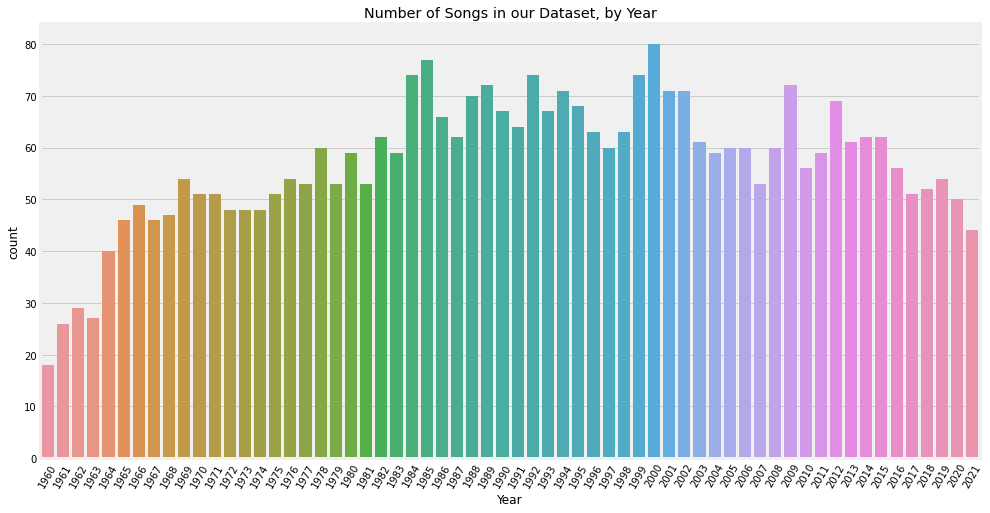

In [9]:
## Create Plot of # of songs per Year
plt.figure(figsize=(15, 8))
ax = sns.countplot(x = "Year", data = good_lyrics_data).set(title = "Number of Songs in our Dataset, by Year")
plt.xticks(rotation=60)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

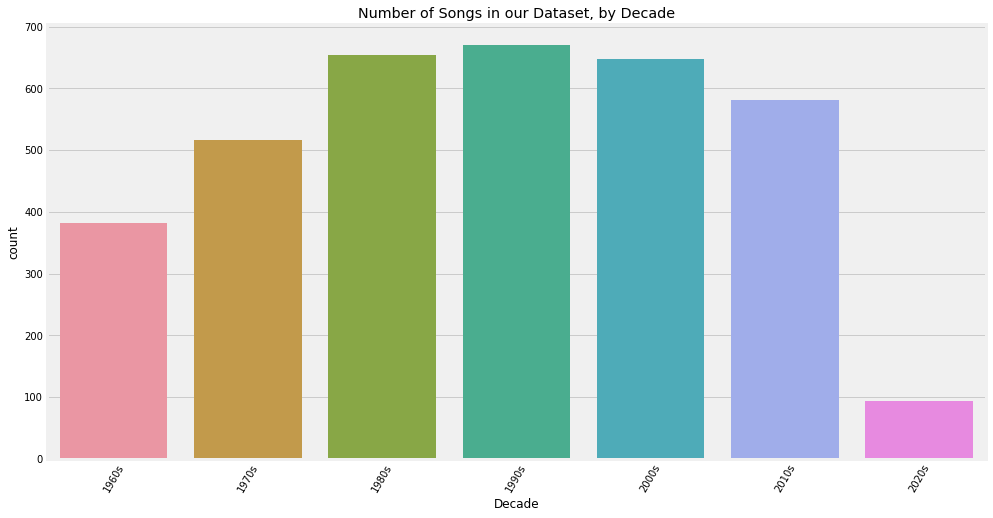

In [10]:
## Create Plot of # of songs per Decade
plt.figure(figsize=(15, 8))
ax = sns.countplot(x = "Decade", data = good_lyrics_data).set(title = "Number of Songs in our Dataset, by Decade")
plt.xticks(rotation=60)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100]),
 <a list of 101 Text major ticklabel objects>)

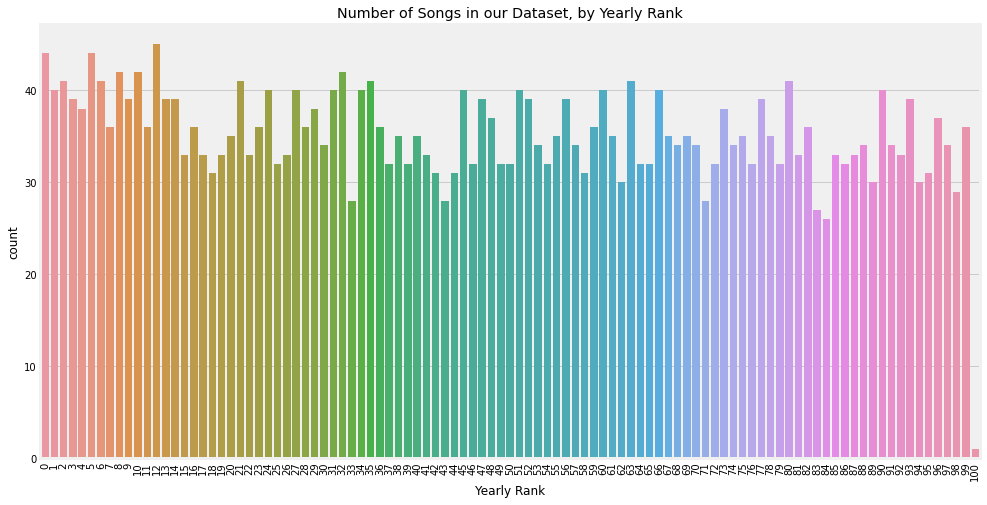

In [11]:
## Create plot of # of songs per Yearly Rank
plt.figure(figsize=(15, 8))
ax = sns.countplot(x = "Yearly Rank", data = good_lyrics_data).set(title = "Number of Songs in our Dataset, by Yearly Rank")
plt.xticks(rotation=90)

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600., 1800.]), <a list of 11 Text major ticklabel objects>)

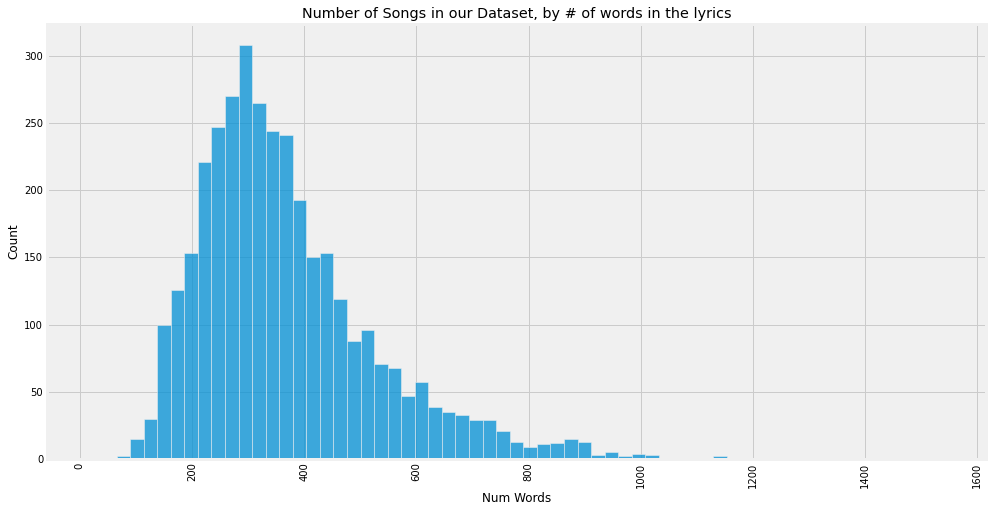

In [12]:
## Create hist of # of Number of words per song
plt.figure(figsize=(15, 8))
ax = sns.histplot(x = "Num Words", data = good_lyrics_data).set(title = "Number of Songs in our Dataset, by # of words in the lyrics")
plt.xticks(rotation=90)

We'll probably need to write a script that checks if the part before "Lyrics" == the "Title"

In [13]:
## Looking into the songs that claim to have more than 600 words
good_lyrics_data[good_lyrics_data["Num Words"] > 600].sort_values("Num Words", ascending = False)

,Year,Yearly Rank,Title,Artist(s),Lyrics,Num Chars,Num Words,Decade
1957,1995,88,"""1st of tha Month""",Bone Thugs-n-Harmony,1st of tha Month Lyrics[Chorus: Layzie Bone & ...,7195,1540,1990s
808,1978,31,"""Take a Chance on Me""",ABBA,Take a Chance on Me Lyrics[Chorus: Agnetha & F...,6711,1243,1970s
2543,2004,58,"""My Band""",D12,"My Band Lyrics[Intro: Eminem] I don't know, du...",5888,1146,2000s
3491,2020,75,"""The Bigger Picture""",Lil Baby,The Bigger Picture Lyrics[Intro] Protests and ...,5706,1145,2020s
2504,2003,97,"""Superman""",Eminem,Superman Lyrics[Intro: Eminem & Dina Rae] Mhmm...,5971,1127,2000s
...,...,...,...,...,...,...,...,...
3351,2018,11,"""Lucid Dreams""",Juice Wrld,Lucid Dreams Lyrics[Intro] Enviyon on the mix ...,2897,603,2010s
2300,2000,95,"""I Don't Wanna""",Aaliyah,"I Don’t Wanna Lyrics[Intro] Ooh, yeah Oh, oh, ...",3034,602,2000s
2788,2008,81,"""Just Fine""",Mary J. Blige,Just Fine Lyrics[Intro] You know I love music ...,3049,601,2000s
2757,2008,27,"""Leavin'""",Jesse McCartney,"Leavin’ Lyrics[Intro] Hmm... [Verse 1] Hey, b...",2906,601,2000s


In [14]:
## Trying to replace all song intros (ie. up to Lyrics) -- WHY IT NO WORK :( 

good_lyrics_data["Lyrics"].str.replace(r"[^\[]*", '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


0                [[[[[
1               [[[[[[
2                  [[[
3       [[[[[[[[[[[[[[
4                   [[
             ...      
3542           [[[[[[[
3543            [[[[[[
3544            [[[[[[
3545              [[[[
3546       [[[[[[[[[[[
Name: Lyrics, Length: 3547, dtype: object